# How to isolate alpha with principal component analysis
[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is used widely in data science. It’s a way to reduce the number of dimensions in a data set. In a stock portfolio, a dimension might be a column of returns for one of the stocks. In a portfolio of 100 stocks, there are 100 dimensions. PCA converts those 100 dimensions into the few that explain the most variance in the data. In other words, the dimensions hold the most information about the data.



## Quants use PCA in many ways
PCA isolates the statistical return drivers of a portfolio. These drivers are called “alpha factors” (or just factors) because they create returns that are not explained by a benchmark. (In a [previous newsletter issue](https://pyquantnews.com/seeking-alpha-hedge-your-beta-with-python/), you learned how to hedge beta to get exposure to alpha.) Quants use factors in trading strategies. First, they isolate the components. Then they buy the stocks with the largest exposure to a factor and sell the stocks with the smallest exposure to a factor. Today you’ll learn how to do this in [Python](https://pyquantnews.com/python-at-netflix/).

## Step 1: Get the data
Start by importing the libraries. sklearn is a package used to build statistical models for data analysis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

from openbb_terminal.sdk import openbb
import matplotlib.pyplot as plt

Next, build a portfolio. You can pick any stocks you want.



In [2]:
symbols = [
    'IBM',
    'MSFT',
    'META',
    'INTC',
    'NEM',
    'AU',
    'AEM',
    'GFI'
]

data = openbb.economy.index(symbols, start_date="2020-01-01", end_date="2022-11-30")

portfolio_returns = data.pct_change().dropna()

## Step 2: Fit a PCA model
sklearn makes it easy to fit a PCA model and get the components.

In [3]:
pca = PCA(n_components=3) # number of principal components
pca.fit(portfolio_returns)

PCA(n_components=3)

The n_components argument tells sklearn how many of the top components to return. Fit the model with the portfolio returns and the algorithm will look for the top three components that explain most of the variance in the returns.



In [4]:
pct = pca.explained_variance_ratio_
pca_components = pca.components_

After you fit the model, grab the explained variance and components (remember the underscore).

## Step 3: Visualize the components
If the description of PCA is unclear, these charts should help.

(0.0, 100.0)

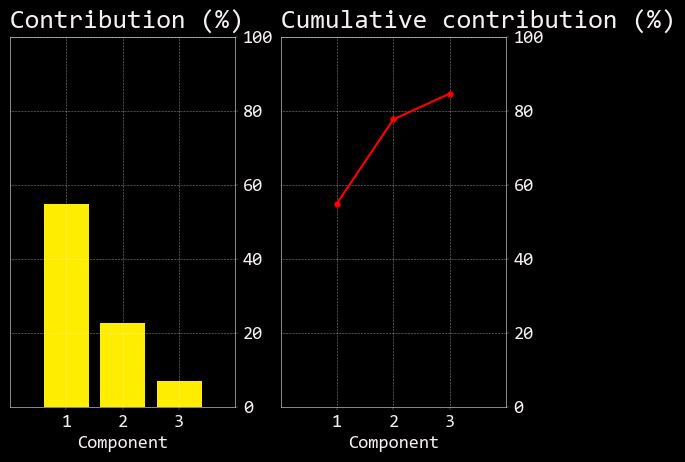

In [5]:
cum_pct = np.cumsum(pct)
x = np.arange(1,len(pct)+1,1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title('Contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

The chart on the left shows the contribution of the top three components toward the total variance. In other words, these components contribute the most to the information in the data. The first component explains 54.9% of the variation in the portfolio returns. In stock portfolios, this is usually driven by the overall market movement.

The chart on the right is the cumulative sum of the contribution of each component. It shows the top three components explain 84.7% of total portfolio returns. There’s no magic cumulative contribution but two or three components explaining close to 85% of the contribution is a good result.

So what does this actually mean?

## Step 4: Isolate the alpha factors
There are forces that move stock prices that we can’t see. These latent factors are picked up through PCA and isolated as the principal components. The overall stock market is usually a strong driver of returns. Macroeconomic forces like interest rates and the pandemic drive returns, too. PCA lets you isolate these statistical factors to get an idea of how much the portfolio’s returns come from these unobserved features.

Let’s take a look.

In [6]:
X = np.asarray(portfolio_returns)
factor_returns = X.dot(pca_components.T)
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"], 
    index=portfolio_returns.index,
    data=factor_returns
)
factor_returns.head()

,f1,f2,f3
Date,,,
2020-01-03,-0.011794,0.015824,-0.007090
2020-01-06,0.009480,-0.010078,-0.013161
2020-01-07,-0.006961,0.009891,-0.008298
2020-01-08,-0.074473,-0.031461,-0.002840
2020-01-09,-0.012222,-0.023795,-0.001387


First, muliply the portfolio returns by the principle components. The dot function makes sure every return is multiplied by each of the components. the T function transposes the DataFrame. The resulting DataFrame gives you how much of that day’s portfolio return is a result of each of the three factors.

Similar stocks will be driven by similar factors. PCA makes it easy to visualize this.

In [7]:
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"], 
    columns=portfolio_returns.columns,
    data = pca_components
).T

factor_exposures

,f1,f2,f3
IBM,0.078962,-0.252226,0.440729
MSFT,0.100812,-0.445576,0.047186
META,0.122527,-0.635266,-0.677004
INTC,0.098114,-0.535771,0.506087
NEM,0.322509,0.011943,0.213583
AU,0.549514,0.123060,-0.037253
AEM,0.375946,0.027935,0.128032
GFI,0.641600,0.176532,-0.160232


<AxesSubplot:>

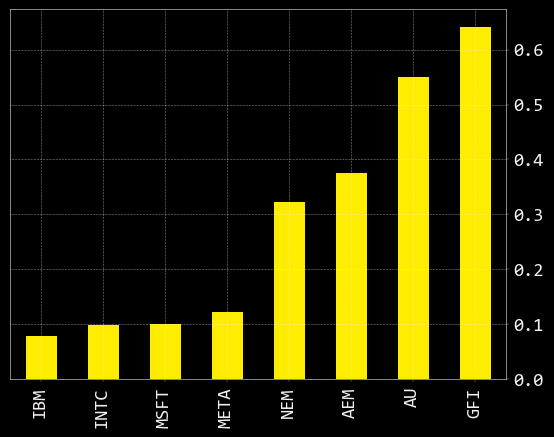

In [8]:
factor_exposures.f1.sort_values().plot.bar()

Analyze the first component. Create a DataFrame with the components, grab the first factor, sort stocks by the component, and plot them. You can see the tech stocks and the gold stocks clustered together. This component is more strongly driving the gold stocks. Can you guess what it is? (Hint: What major global event took place between January 2020 through November 2022?)



Another great way to visualize this is with a scatter plot.

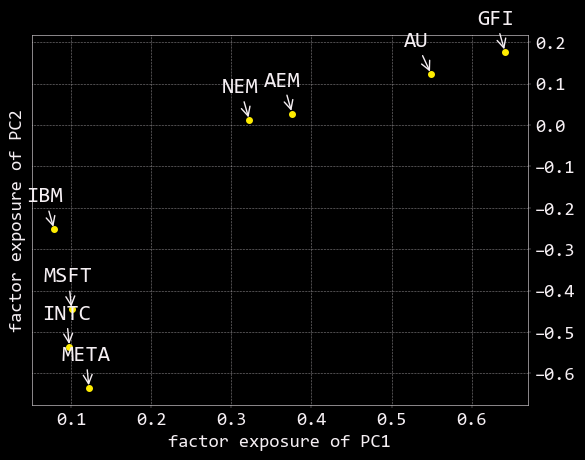

In [9]:
labels = factor_exposures.index
data = factor_exposures.values
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('factor exposure of PC1')
plt.ylabel('factor exposure of PC2')

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), 
        xytext=(-20, 20),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
    );

You can see how the stocks are driven by the first two principal components. Gold stocks were largely driven by factor one and tech stocks were negatively driven by factor two.

This analysis covered the time period during covid. Gold stocks were bid up strongly as a hedge against inflation and uncertainty. You might consider the first factor as a “covid factor” representing uncertainty across the market. Tech stocks crashed as worries of economic health began.